# Azure Connection for the data base.


## -issue: Blobs DB does not have an inherent indices system.

## -issue: croping in vertical direction (axis = 1) does NOT work for all images. 

In [189]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__
import os
from datetime import datetime
import time
import shutil
import cv2
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import glob,re
from itertools import combinations, product
import math
import imutils
import random

%matplotlib inline

In [190]:
local_dir = './d1'

if not os.path.exists(local_dir): os.makedirs(local_dir)
    
target_dir = './d2'

if not os.path.exists(target_dir): os.makedirs(target_dir)

In [191]:
shutil.rmtree(local_dir) #delete directory d1
shutil.rmtree(target_dir) #delete directory d2

In [192]:
# Azure connecting info. 
os.environ['AZURE_STORAGE_CONNECTION_STRING'] = 'DefaultEndpointsProtocol=https;AccountName=blobsdb;AccountKey=tJK43kihAcaeZMjcegWFcyg8tsFmOr9f2Kn8q6NUinVSJW5O3jymYbjaiGBjmx8Ibq5LsBVPcABvYeV+tUCPnQ==;EndpointSuffix=core.windows.net'
connect_str = os.getenv('AZURE_STORAGE_CONNECTION_STRING')
# Create the BlobServiceClient object which will be used to create a container client.
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

In [193]:
def retrieve_last_k_containers(k):
    
    "function retrieve last k containers from Azure Blobs Storage"

    container_list=[]
    # list containers
    for i,item in enumerate(reversed(list(blob_service_client.list_containers()))):
        if i ==k:
            break
        print(datetime.fromtimestamp(int(item["name"].split("-")[0])))
        container_list.append(item["name"])
    return container_list

In [194]:
container_list=retrieve_last_k_containers(5)

2021-12-06 16:11:35
2021-12-06 15:49:22
2021-12-06 14:59:03
2021-12-06 14:08:44
2021-12-06 13:18:25


# Download files - blobs

In [195]:
def dl_blobs_to_local(container_list):
    for container in container_list:
        dir_name = local_dir + "/" + container
        try :
            os.makedirs(dir_name)
        except FileExistsError:
            continue
            
        container_client = blob_service_client.get_container_client(container)
        for blob in container_client.list_blobs():
            save_blob(blob.name,dir_name,container_client)
            
            
def save_blob(blob_name,dir_name,container_client):
    
    "function downloads and saves one blob"
    
    with open(dir_name+"/"+ str(blob_name), "wb") as my_blob:
        blob_client = container_client.get_blob_client(blob_name) # Instantiate a new BlobClient
        download_stream = blob_client.download_blob()
        my_blob.write(download_stream.readall())

In [196]:
dl_blobs_to_local(container_list) #download from server

# Masking 
## how to mask the raspberry HQ camera output:

A.Pre Defined masking - Not good because every change in the setup requires retuning the mask parameters. 

B. Masking by motion detection, use image substraction, this approach we will try here. see below.

C. NN that object detects the desired object in the picture and set boundaries. (mask R-CNN and like)

## Contant parameters masking function (option A)

In [197]:
def mask_images(img_path, erode_func, output_lib, params, output_ext=".jpg"):
   

    """:param img_path: string, path to the image.
       :param erode_func: function, masking function.
       :param output_lib: string, path to output directory.
       :param output_ext: string, type of output image, default jpg.
       :param params: dictionary mask- parameters.

       :returns np.arrays of g_img, mask_g and img

       """

    # set cropping and masking parameters:
    hlc, hrc, vlc, vuc = params["hlc"], params["hrc"], params["vlc"], params["vuc"]
    n, n_iter = params["n"], params["n_iter"]

    # extract img name:
    img_name = os.path.splitext(Path(img_path).name)[0]

    # output name
    g_img_path = output_lib + '/' + 'gr_' + img_name + output_ext  # output path to g_img

    img = cv2.imread(img_path)[vlc:vuc, hlc:hrc]  # cv2 read & crop
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # convert to hsv
    mask = cv2.inRange(hsv, (35, 25, 25), (80, 255, 255))  # mask by slicing the green spectrum
    # mask = cv2.inRange(hsv, (0, 42, 0), (179, 255, 255)) # everything except white

    # apply the masking:
    imask = mask > 0
    g_img = np.zeros_like(img, np.uint8)
    mask_g = np.zeros_like(img, np.uint8)

    # make white background
    g_img.fill(255)
    g_img[imask] = img[imask]
    mask_g[~imask] = img[~ imask]
    mask_g[mask_g != 0] = 255

    # erosion
    g_img, mask, img = erode_func(img, mask_g, n, n_iter)

    # save to directory
    cv2.imwrite(g_img_path, g_img)

    return g_img, mask, img

# Motion Detection (option B)

In [201]:
def fetch_random(cam,last=False):
    " returns 3 consecutive random imgs "
    
    if last:
        container = sorted(glob.glob(local_dir+"/*"))[-1]
    else:
        container=random.choice(glob.glob(local_dir+"/*"))
    possibilities = sorted(glob.glob(container+f"/{cam}*"))
    x,y,z= random.choice([(i,i+1,i+2) for i in range(len(possibilities)-2)])
   
    return possibilities[x],possibilities[y],possibilities[z]

In [202]:
img1,img2,img3 = fetch_random("56",last=True)

In [203]:
img1,img2,img3

('./d1/1638803495-958193/56img18-86.jpg',
 './d1/1638803495-958193/56img19-38.jpg',
 './d1/1638803495-958193/56img19-86.jpg')

In [204]:
im1 = cv2.imread(img1)
im2 = cv2.imread(img2)
im3 = cv2.imread(img3)

im1_np = np.int32(im1)
im2_np = np.int32(im2)
im3_np = np.int32(im3)

im13_np=cv2.subtract(im1_np,im3_np)
im23_np=cv2.subtract(im2_np,im3_np)
im12_np=cv2.subtract(im1_np,im2_np)

gray1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
gray3 = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)

gray12=cv2.subtract(gray1,gray2)
gray13=cv2.subtract(gray1,gray3)
gray23=cv2.subtract(gray2,gray3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


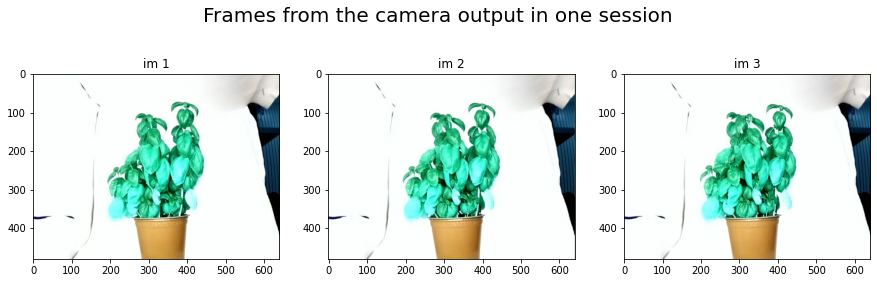

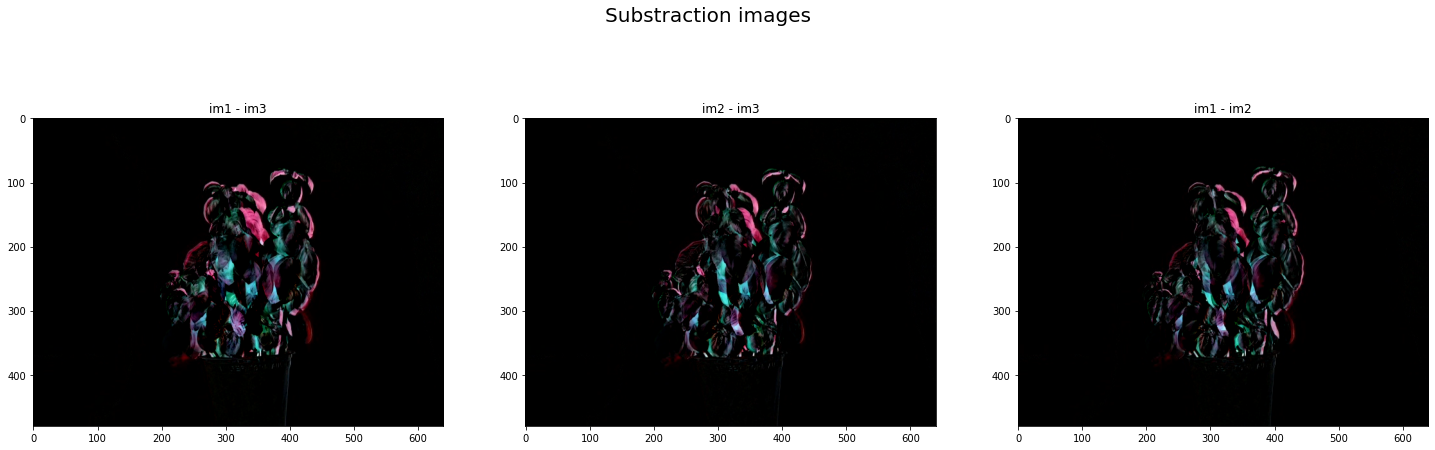

In [205]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15,15))
fig.suptitle('Frames from the camera output in one session', fontsize=20,y=0.65)
axs[0].imshow(im1);
axs[0].title.set_text('im 1');
axs[1].imshow(im2);
axs[1].title.set_text('im 2');
axs[2].imshow(im3);
axs[2].title.set_text('im 3');


fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(25,25))
fig.suptitle('Substraction images', fontsize=20,y=0.65)

axs[0].imshow(im13_np);
axs[0].title.set_text('im1 - im3');
axs[1].imshow(im23_np);
axs[1].title.set_text('im2 - im3');
axs[2].imshow(im12_np);
axs[2].title.set_text('im1 - im2');

# Cropping indices

In [206]:
def derivative(series, interval=1):
    
    """derivative auxiliary"""
    
    diff = list()
    for i in range(len(series)):
        value = series[i] - series[i - interval]
        diff.append(value)
    return np.array(diff)

def find_crop_indices(img_diff,axis=0):
    
    #reduce img to vertical mean vector
    M = img_diff.mean(axis=axis)
    
    #compute median for clipping
    M_median = (M.max()-M.min())/2
    
    
    M_threshold = M_median/2 if axis == 0 else 1.1*M_median
    #aux clipper
    clip = lambda t : 0 if t-M_threshold < 0 else t 
    
    #apply on mean vec on M
    M_mod = np.array([clip(t) for t in M])
    
    #find suspected points for the main objects' boundaries
    right,left = find_turning_pts(abs(derivative(M_mod)),50) 
    
    #compute the biggest component 
    ind_max=np.argmax(list(map(int.__sub__, left, right)))
    
    # safety intervel to be added
    M_safe=100 if axis==0 else 150
    crop_interval= (max(0,right[ind_max]-M_safe),min(len(M_mod),left[ind_max]+M_safe)) 
    
    hlc,hrc = crop_interval
    return hlc,hrc

def find_turning_pts(M,interval):
    
    """function searches for left/right jumping points in M, 
        :param: interval is an integer representing a sequel of zeros which should come before/after the suspected
        point"""
    
    left=[]
    right=[]
    
    for t in range(interval,len(M)):
        if M[t] != 0:
            for j in range(1,interval+1):
                if M[t-j] !=0:
                    break
            if j == interval:
                left.append(t)
                              
                
    for t in range(0, len(M)-interval):
        if M[t] != 0:
            for j in range(1,interval+1):
                if M[t+j] !=0:
                    break
            if j == interval:
                right.append(t)
    
    
    return [0]+left+[len(M)],[0]+right+[len(M)]

## - vertical axis: 0
## - horizontal axis: 1

# Plot greyscale differences with crop (axis = 0)

139 536
145 544
145 544


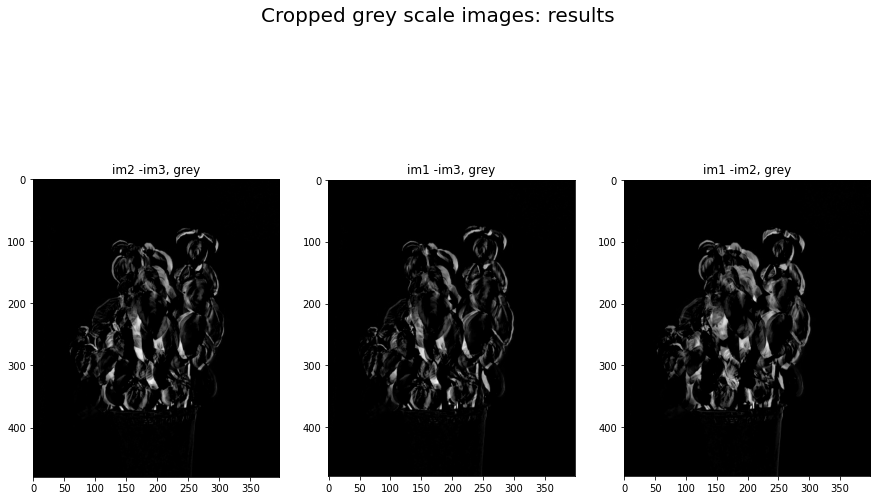

In [207]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15,15))
fig.suptitle('Cropped grey scale images: results', fontsize=20,y=0.8)

l,r = find_crop_indices(gray23)
print(l,r)
axs[0].imshow(gray23[:,l:r], cmap=plt.cm.binary_r);
axs[0].title.set_text('im2 -im3, grey');


l,r = find_crop_indices(gray13)
print(l,r)
axs[1].imshow(gray12[:,l:r], cmap=plt.cm.binary_r);
axs[1].title.set_text('im1 -im3, grey');


l,r = find_crop_indices(gray12)
print(l,r)
axs[2].imshow(gray13[:,l:r], cmap=plt.cm.binary_r);
axs[2].title.set_text('im1 -im2, grey');


# Plot greyscale differences with crop (both axes)

139 536 0 480
145 544 0 480
145 544 0 480


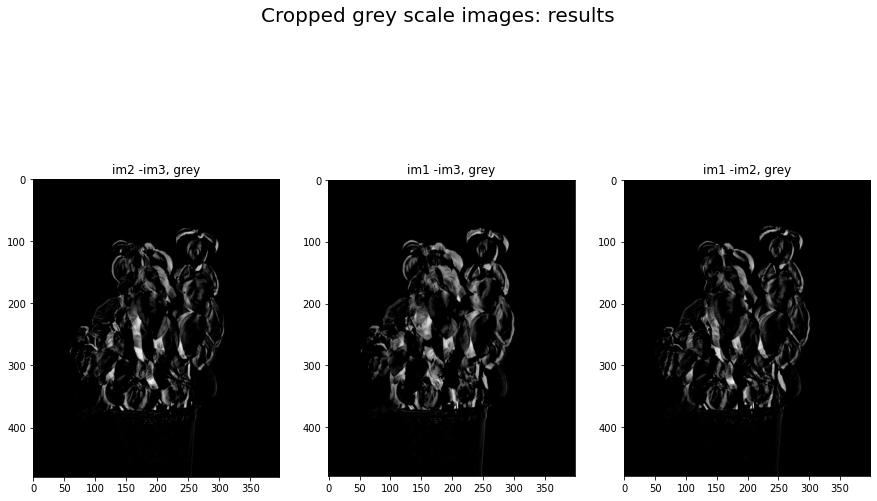

In [208]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15,15))
fig.suptitle('Cropped grey scale images: results', fontsize=20,y=0.8)


img = gray23
hl,hr = find_crop_indices(img,axis=0)
vl,vr = find_crop_indices(img,axis=1)
print(hl,hr,vl,vr)
axs[0].imshow(img[vl:vr,hl:hr], cmap=plt.cm.binary_r);
axs[0].title.set_text('im2 -im3, grey');


img = gray13
hl,hr = find_crop_indices(img,axis=0)
vl,vr = find_crop_indices(img,axis=1)
print(hl,hr,vl,vr)
axs[1].imshow(img[vl:vr,hl:hr], cmap=plt.cm.binary_r);
axs[1].title.set_text('im1 -im3, grey');


img = gray12
hl,hr = find_crop_indices(img,axis=0)
vl,vr = find_crop_indices(img,axis=1)
print(hl,hr,vl,vr)
axs[2].imshow(img[vl:vr,hl:hr], cmap=plt.cm.binary_r);
axs[2].title.set_text('im1 -im2, grey');

# analysis (Explicit)

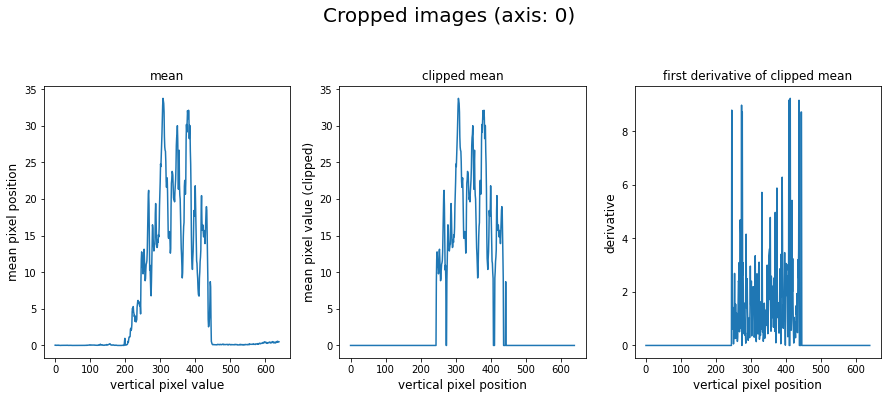

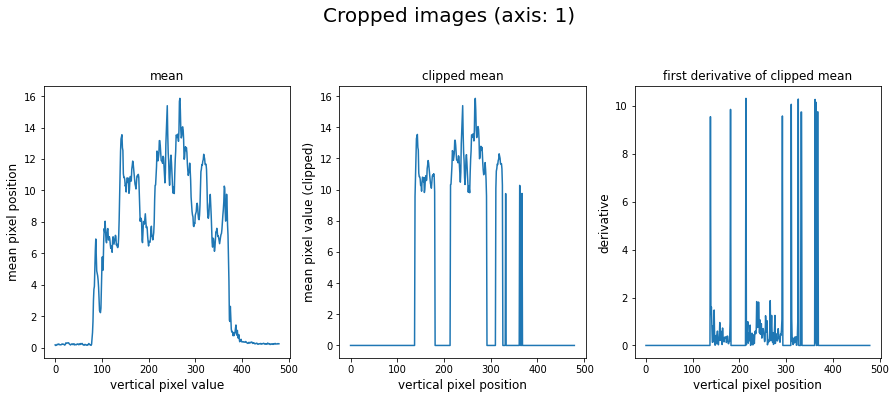

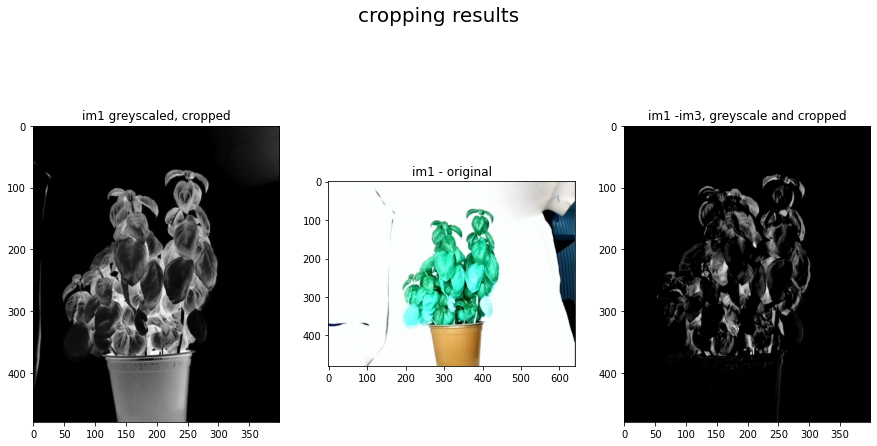

In [209]:
for ax in [0,1]:
    
    M=gray13.mean(axis=ax)
    M_median=(M.max()-M.min())/2
    M_threshold = M_median/2 if ax == 0 else M_median*1.2
    clip = lambda t : 0 if t-M_threshold < 0 else t
    M_mod = np.array([clip(t) for t in M])

    fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
    fig.suptitle(f'Cropped images (axis: {ax})', fontsize=20,y=1.1)

    axs[0].plot(M);
    axs[0].set_title("mean");
    axs[0].set_xlabel('vertical pixel value', fontsize=12);
    axs[0].set_ylabel('mean pixel position', fontsize=12);

    axs[1].plot(M_mod);
    axs[1].set_title("clipped mean");
    axs[1].set_xlabel('vertical pixel position', fontsize=12);
    axs[1].set_ylabel('mean pixel value (clipped)', fontsize=12);


    axs[2].plot(abs(derivative(M_mod)));
    axs[2].set_title("first derivative of clipped mean");
    axs[2].set_xlabel('vertical pixel position', fontsize=12);
    axs[2].set_ylabel('derivative', fontsize=12);
    
    
    # search for horizontal cropping interval by taking derivative.
    right,left=find_turning_pts(abs(derivative(M_mod)),50)

    # taking difference of l/r jumping points found in right,left
    moving_int_size=list(map(int.__sub__, left, right))

    # biggest interval
    ind_max=np.argmax(moving_int_size)

    # safety enlarge the found-before cropping interval.
    if ax == 0:
        M=100
        hlc,hrc= (max(0,right[ind_max]-M),min(len(M_mod),left[ind_max]+M))
    else: 
        M=150
        vlc,vrc= (max(0,right[ind_max]-M),min(len(M_mod),left[ind_max]+M))
    
# plot
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15,15))
fig.suptitle('cropping results', fontsize=20,y=0.75)

axs[0].imshow(gray1[vlc:vrc, hlc:hrc], cmap=plt.cm.binary);
axs[0].title.set_text('im1 greyscaled, cropped');

axs[1].imshow(im1);
axs[1].title.set_text('im1 - original');

axs[2].imshow(gray13[vlc:vrc, hlc:hrc], cmap=plt.cm.binary_r);
axs[2].title.set_text('im1 -im3, greyscale and cropped');

In [241]:
def organize_container(container_path):
    
    """ recieves containers path, 
    returns dictionary, keys are camerasIds, values are path_to_image´s. """
    
    files = [file.split("/")[-1] for file in glob.glob(container_path + "/*")]
    cameras = list(set([file[0:2] for file in files]))
    d={}
    
    # dict init
    for cam in cameras:
        d[cam]=[]
    for file in files:
        d[file[0:2]].append(container_path + "/" + file)
    for cam in cameras:
        d[cam]=sorted(d[cam])
            
    return d

def crop_session(d):
    
    def compute_diffs(im1,im2,im3):
        return [cv2.subtract(im2,im1),cv2.subtract(im3,im2)]
 
    cameras = list(d.keys())
    d_grey={}
    result_dict = {}
    
    
    for cam in cameras:  
        grey = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY) for img in d[cam]]
        img_inds = [x for x in range(len(grey))]
        
        for ind in img_inds:
            diff_ind = list(np.argsort([abs(x - ind) for x in [x for x in range(len(grey))]] )[:3])
            d_im1,d_im2 = compute_diffs(grey[diff_ind[1]],grey[diff_ind[0]],grey[diff_ind[2]])
            
            
            hl1,hr1 = find_crop_indices(d_im1,axis=0)
            hl2,hr2 = find_crop_indices(d_im2,axis=0)
            vl1,vr1 = find_crop_indices(d_im1,axis=1)
            vl2,vr2 = find_crop_indices(d_im2,axis=1)
            
            
            hlc,hrc= min(hl1,hl2),max(hr1,hr2)
            vlc,vrc= min(vl1,vl2),max(vr1,vr2)
            
            result_dict[d[cam][ind]] = (hlc,hrc,vlc,vrc)
            
    return result_dict 

def crop_all_and_plot(apply_mask=False, save_to_local=False, rescale=False,plot=True):
    
    container_list = sorted(glob.glob(local_dir+"/*"))
    
    for container_path in container_list:
    
        d = organize_container(container_path);
        #N = int(math.ceil(math.sqrt(len([item for sublist in list(d.values()) for item in sublist]))))
        N= int(math.ceil(len([item for sublist in list(d.values()) for item in sublist])) / 4 )
        M = 4
        #N = math.ceil(len(list(d.values()))/4)
        dict_w_crop = crop_session(d);
        
        if plot:
            fig, axs = plt.subplots(nrows=N, ncols=M,figsize=(20,20));
            fig.suptitle(f'cropping results {container_path}', fontsize=20,y=1);
            #fig.tight_layout();
        

        for i,j in product(range(N),range(M)):
            
            try:
                img_path, crop = dict_w_crop.popitem();
                hlc, hrc, vlc, vrc = crop;
            except KeyError:
                continue
            
            #apply mask: Green HSV,dilate,erode 
            if apply_mask:
                img, _ ,_ = mask_function(img_path,hlc,hrc,vlc,vrc)
            else:
                img = cv2.imread(img_path)[vlc:vrc,hlc:hrc]
                
            #rescaling image to WxH by padding
            if rescale:
                img=pad(img,h=480,w=640)
            
            #plotting
            if plot:
                axs[i,j].set_title(img_path.split("/")[-1]);
                axs[i,j].imshow(img);
            
            # save to directory
            if save_to_local:
                
                if not os.path.exists(target_dir+"/"+img_path.split("/")[-2]): os.makedirs(target_dir+"/"+img_path.split("/")[-2])
                
                cv2.imwrite(target_dir+"/"+img_path.split("/")[-2]+"/"+img_path.split("/")[-1], img)
                
                
def erode_function(img, mask, ker, ite):
    kernel = np.ones((ker, ker), np.uint8)
    mask_erosion = cv2.erode(mask, kernel, iterations=ite)
    imask_erosion = mask_erosion == 0
    g_img = np.zeros_like(img, np.uint8)
    g_img.fill(255)
    g_img[imask_erosion] = img[imask_erosion]
    
    return g_img, mask_erosion, img

def dilate_function(img, mask, ker, ite):
    kernel = np.ones((ker, ker), np.uint8)
    mask_dilate = cv2.dilate(mask, kernel, iterations=ite)
    imask_dilate = mask_dilate == 0
    g_img = np.zeros_like(img, np.uint8)
    g_img.fill(255)
    g_img[imask_dilate] = img[imask_dilate]
    
    return g_img, mask_dilate, img

def mask_function(img_path,hlc,hrc,vlc,vrc):
    
    img = cv2.imread(img_path)[vlc:vrc, hlc:hrc]  # cv2 read & crop
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # convert to hsv
    mask = cv2.inRange(hsv, (40, 28, 28), (80, 255, 255))  # mask by slicing the green spectrum
    # apply the masking:
    g_img = np.zeros_like(img, np.uint8)
    mask_g = np.zeros_like(img, np.uint8)
    g_img.fill(255)
    g_img[mask > 0] = img[mask > 0]
    
    mask_g[~mask > 0] = img[~mask > 0]
    mask_g[mask_g != 0] = 255
    # erosion and dilation
    g_img , mask, img = dilate_function(img, mask_g, 3, 5)
    g_img, mask, img = erode_function(img, mask, 6,20)
    return g_img, mask, img 


def pad(img, h, w):
    #  in case when you have odd number
    top_pad = int(np.floor((h - img.shape[0]) / 2))
    bottom_pad = int(np.ceil((h - img.shape[0]) / 2))
    right_pad = int(np.ceil((w - img.shape[1]) / 2))
    left_pad = int(np.floor((w - img.shape[1]) / 2))
    return np.copy(np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode='constant', constant_values=255))


# Plot cropping

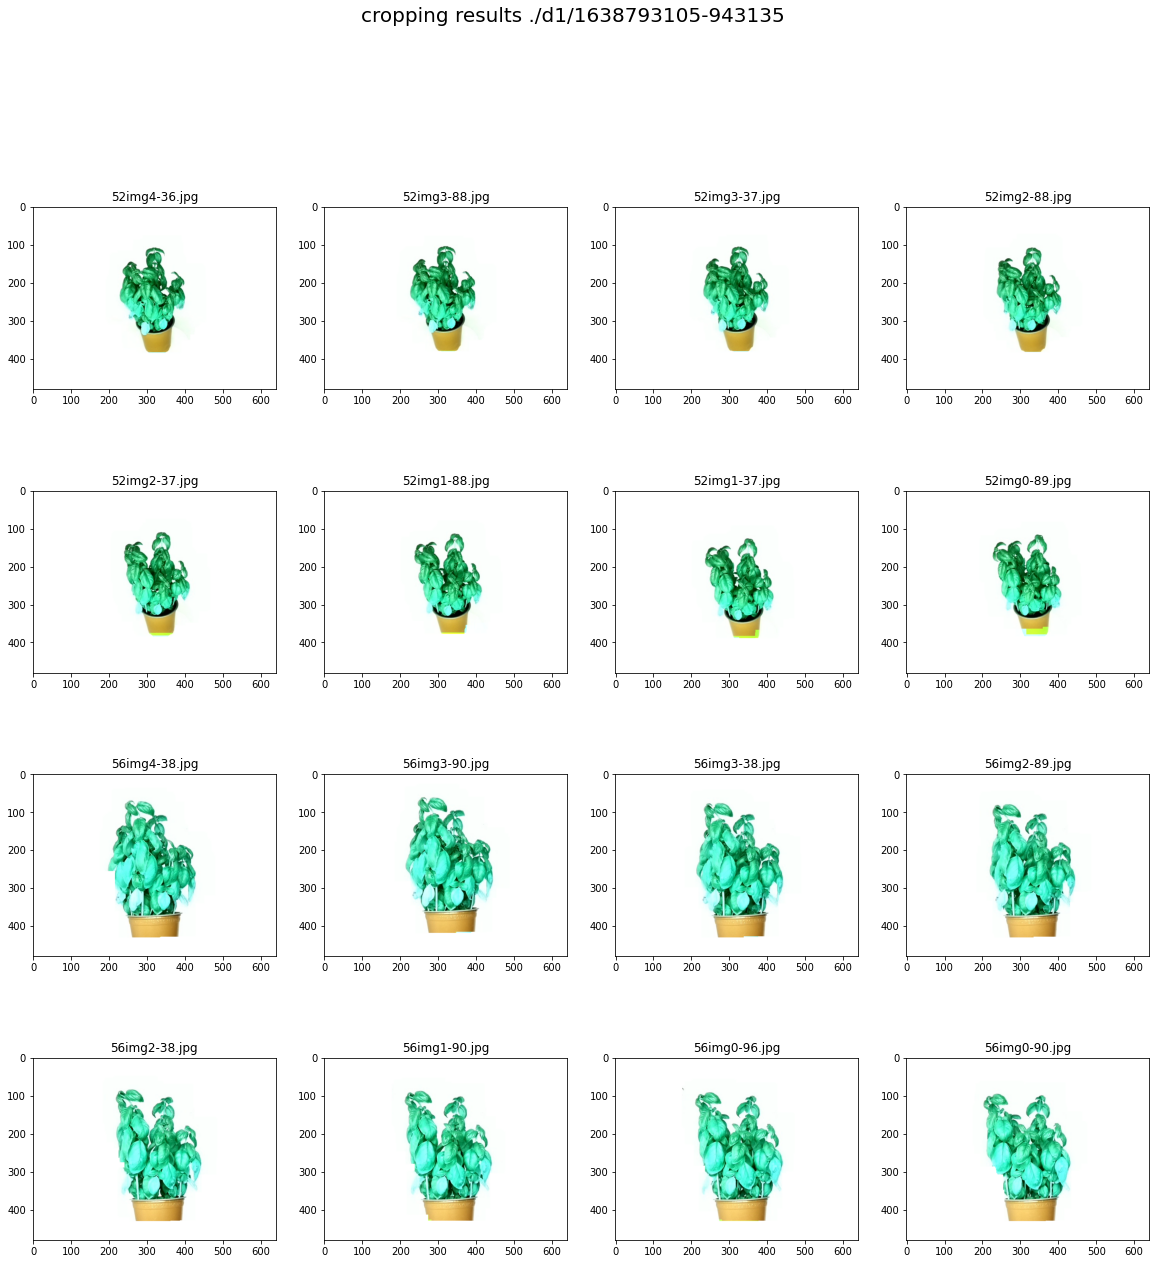

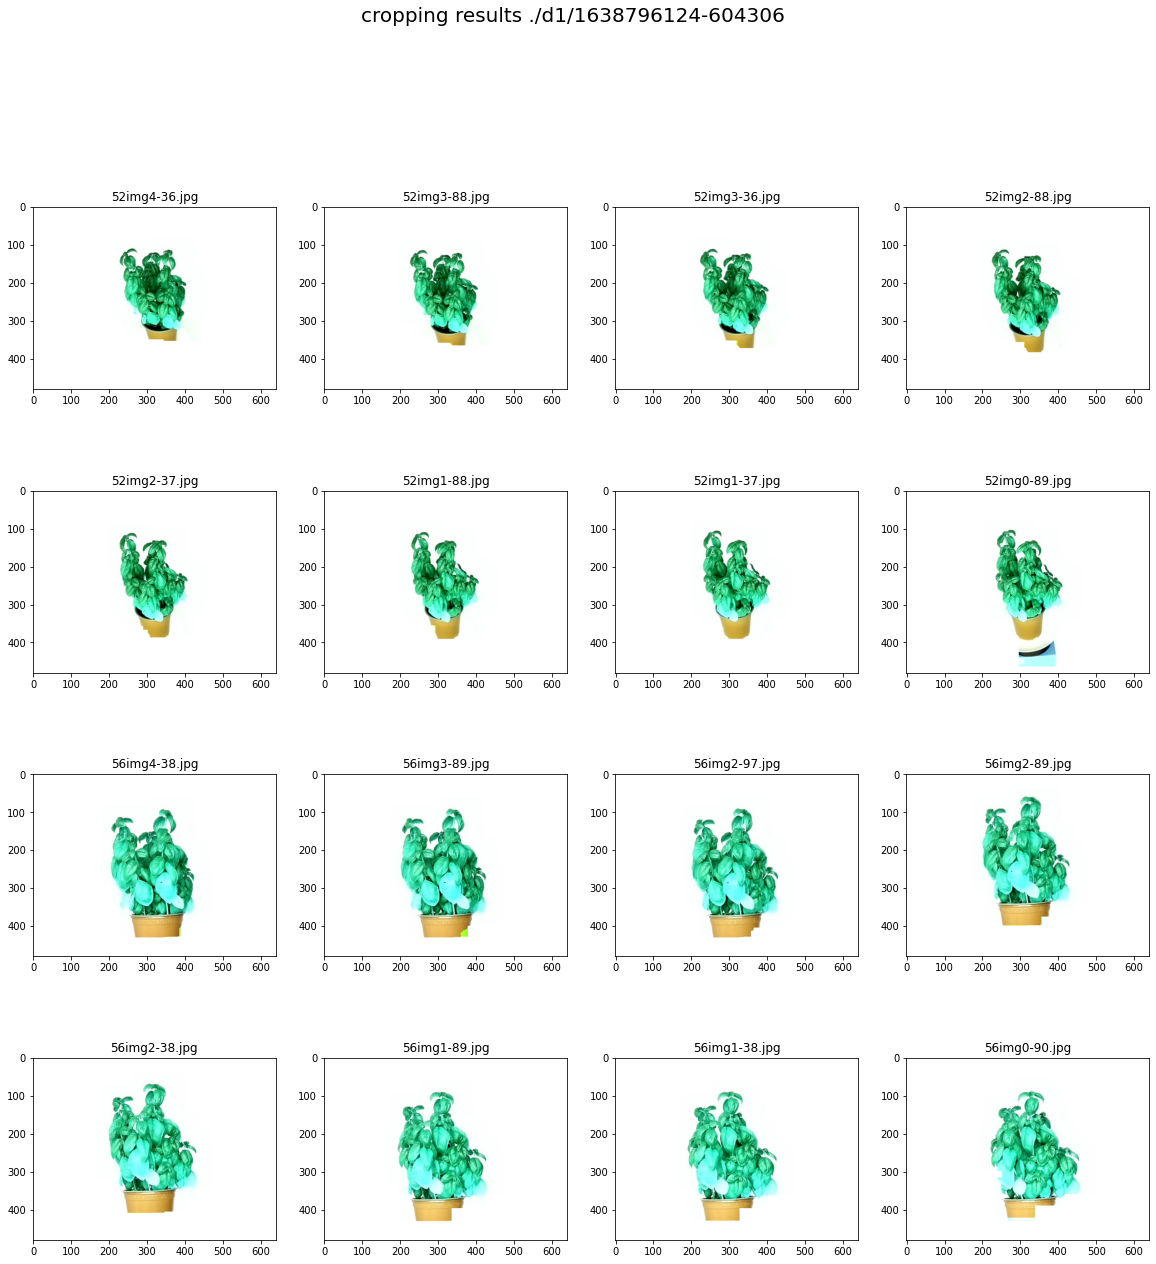

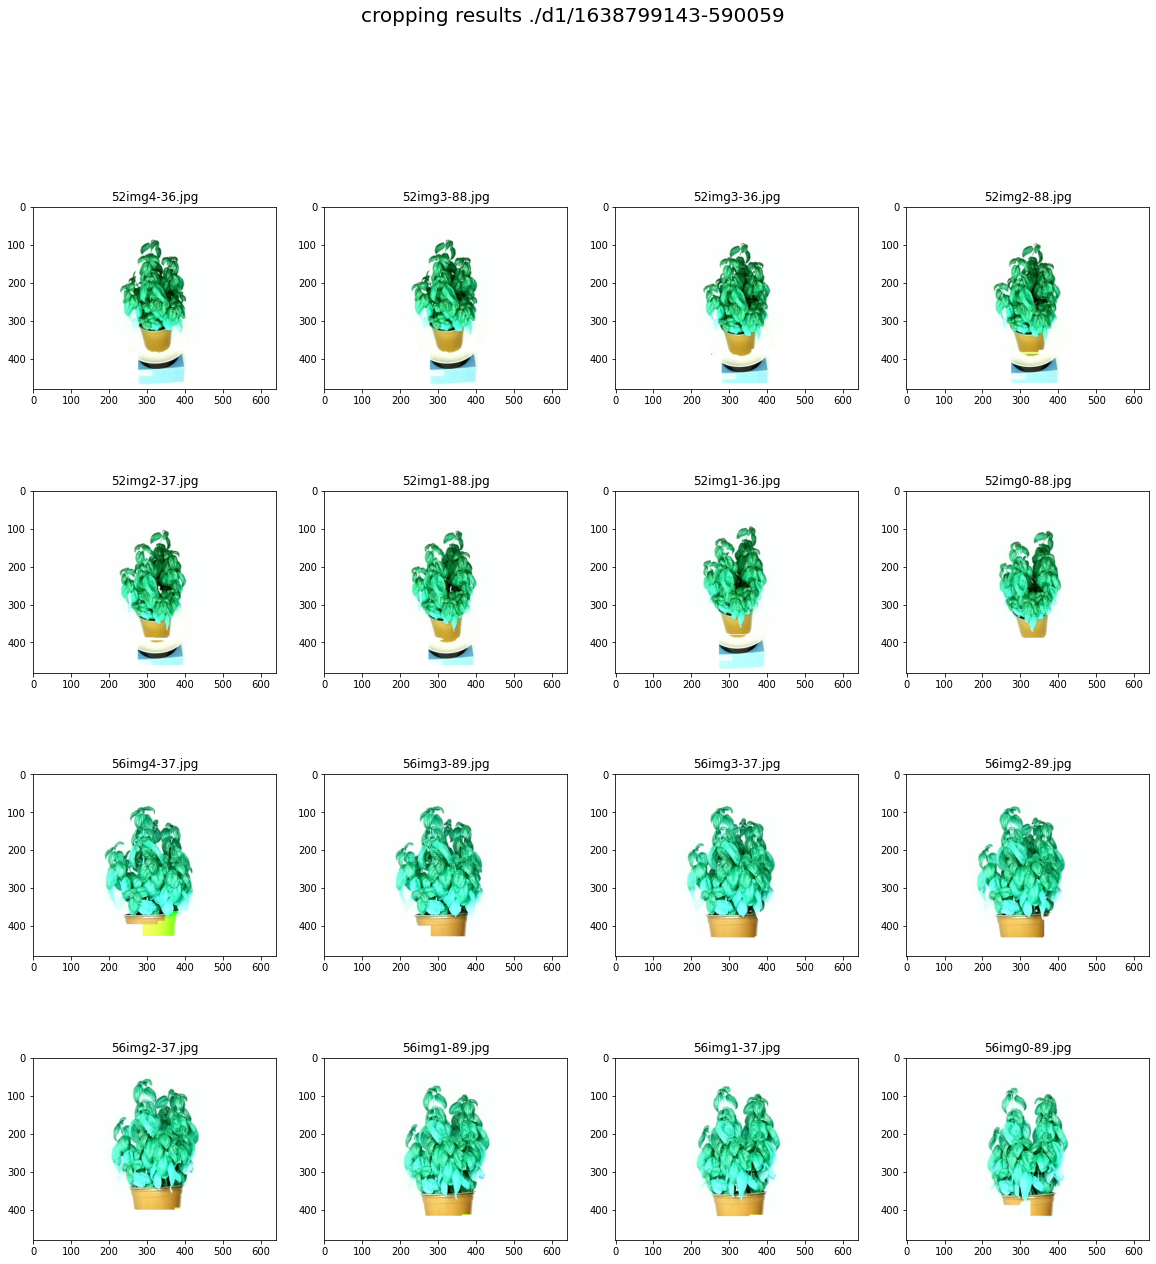

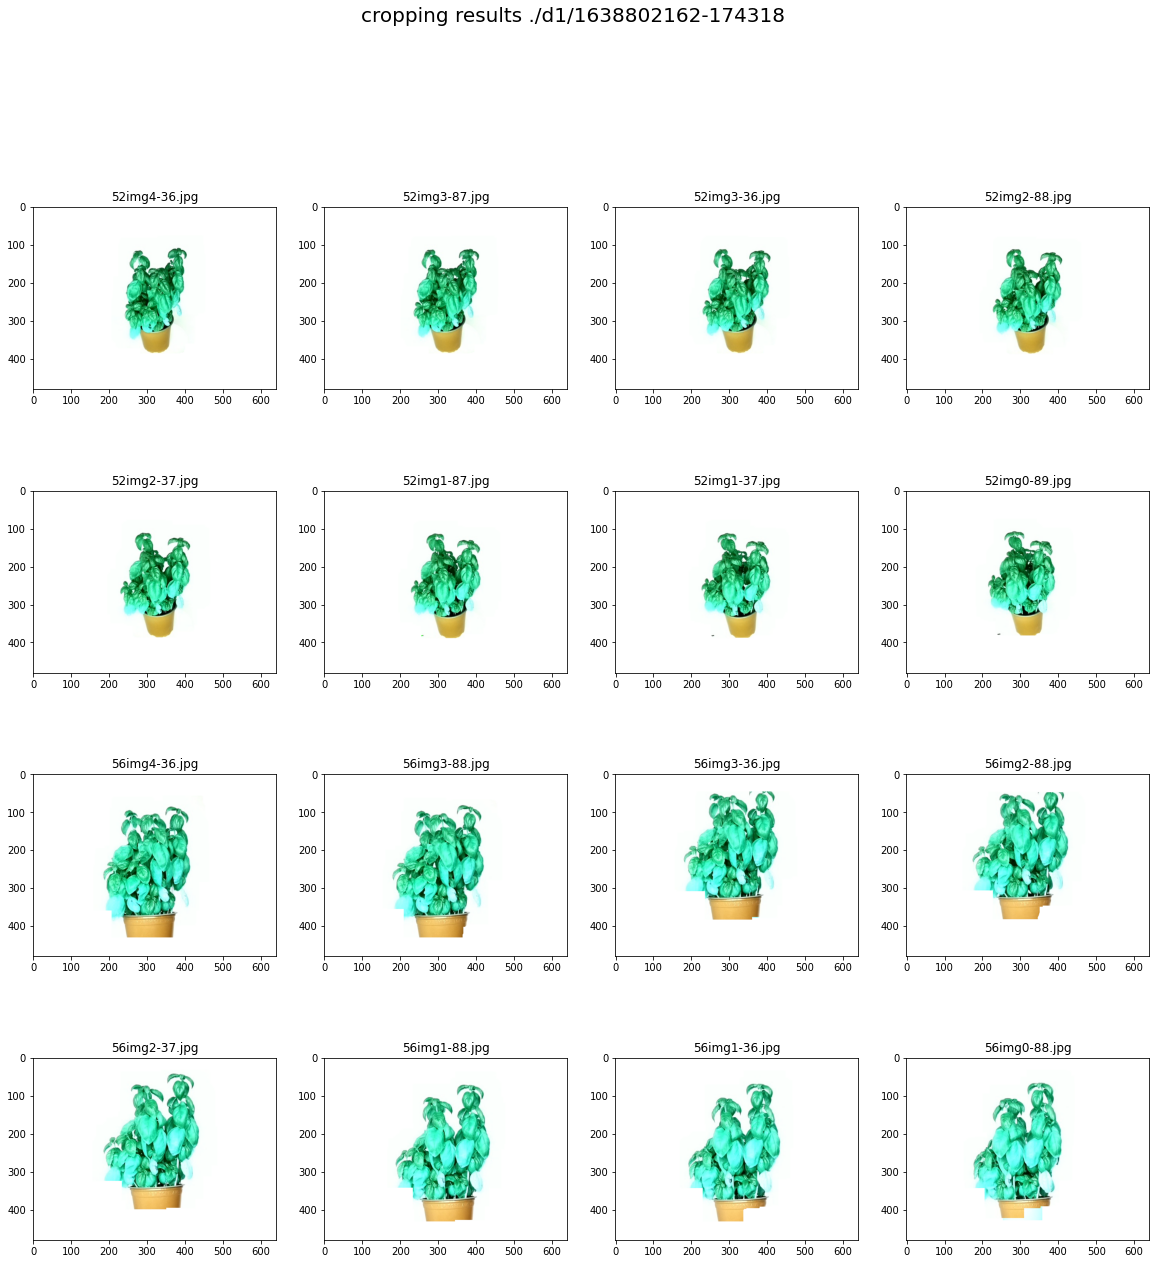

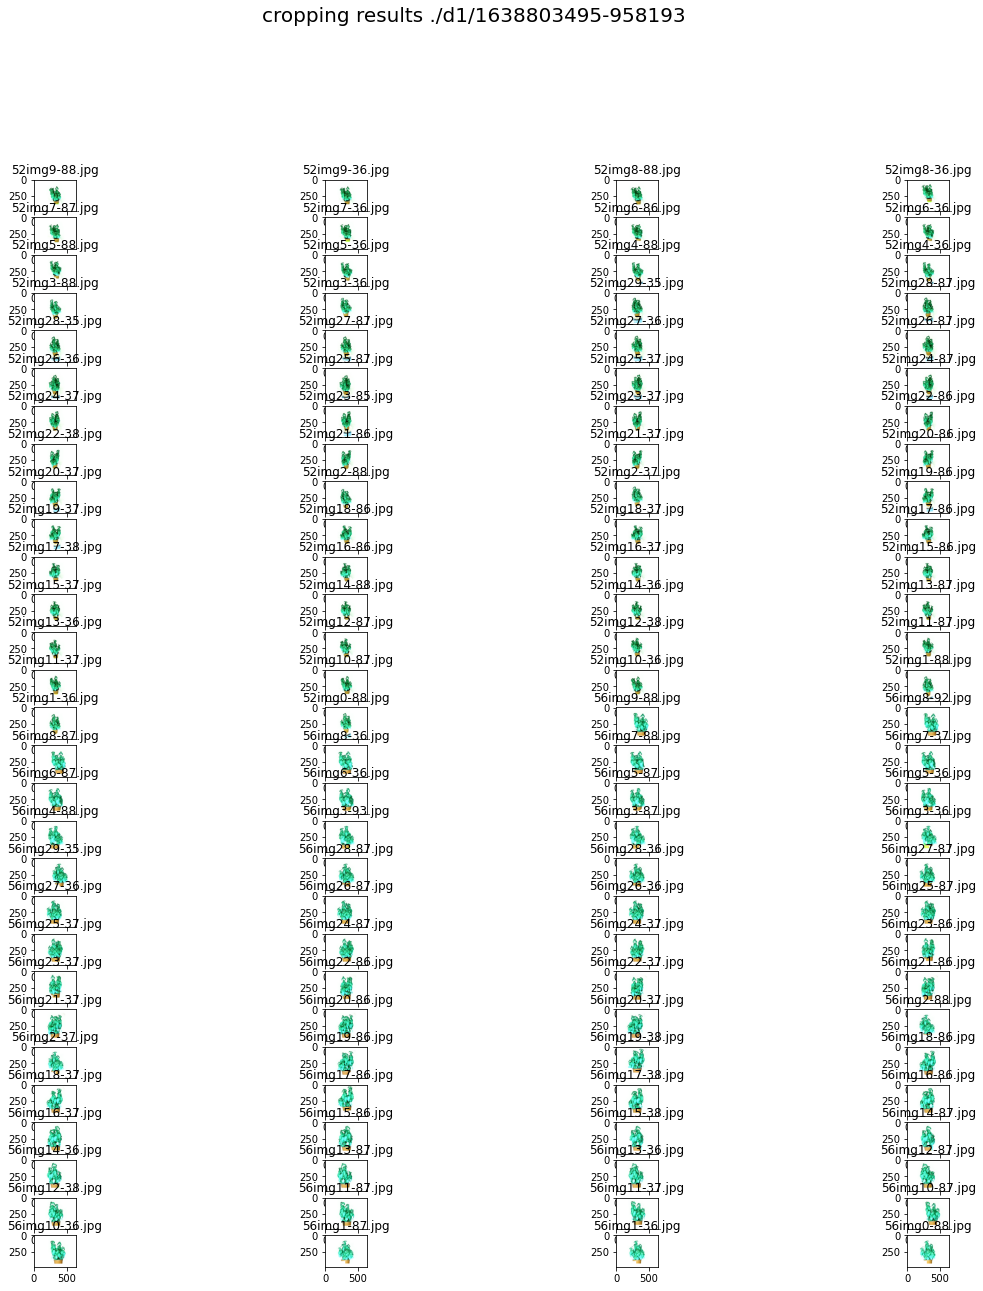

In [242]:
crop_all_and_plot(apply_mask=True,rescale= True)

# Green Spectrum Masking 

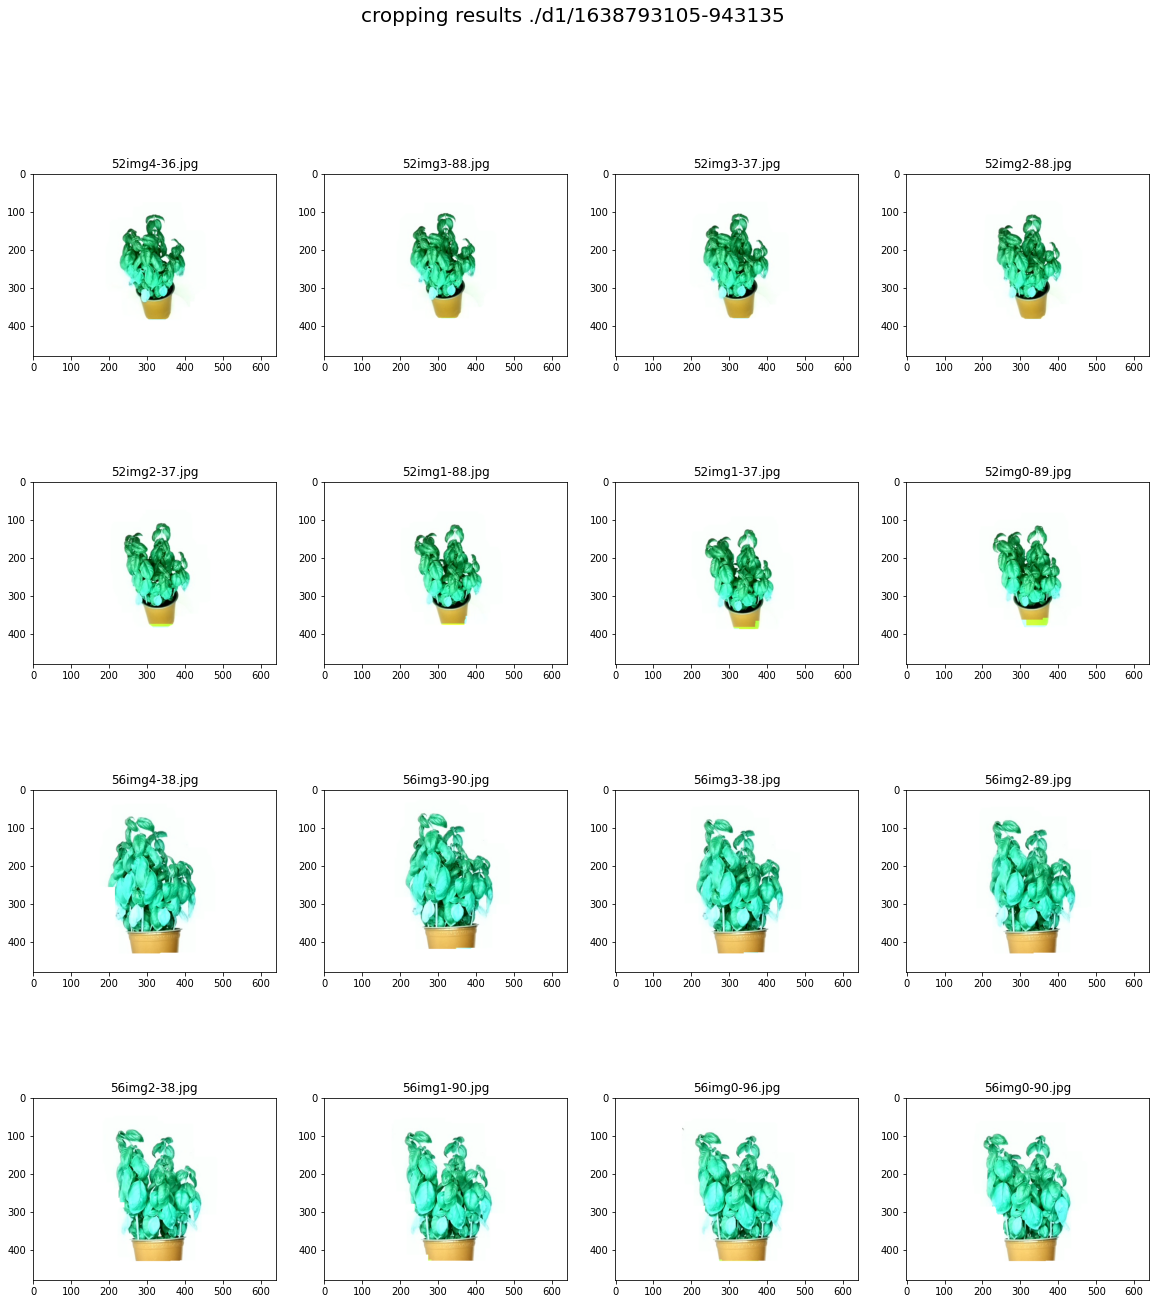

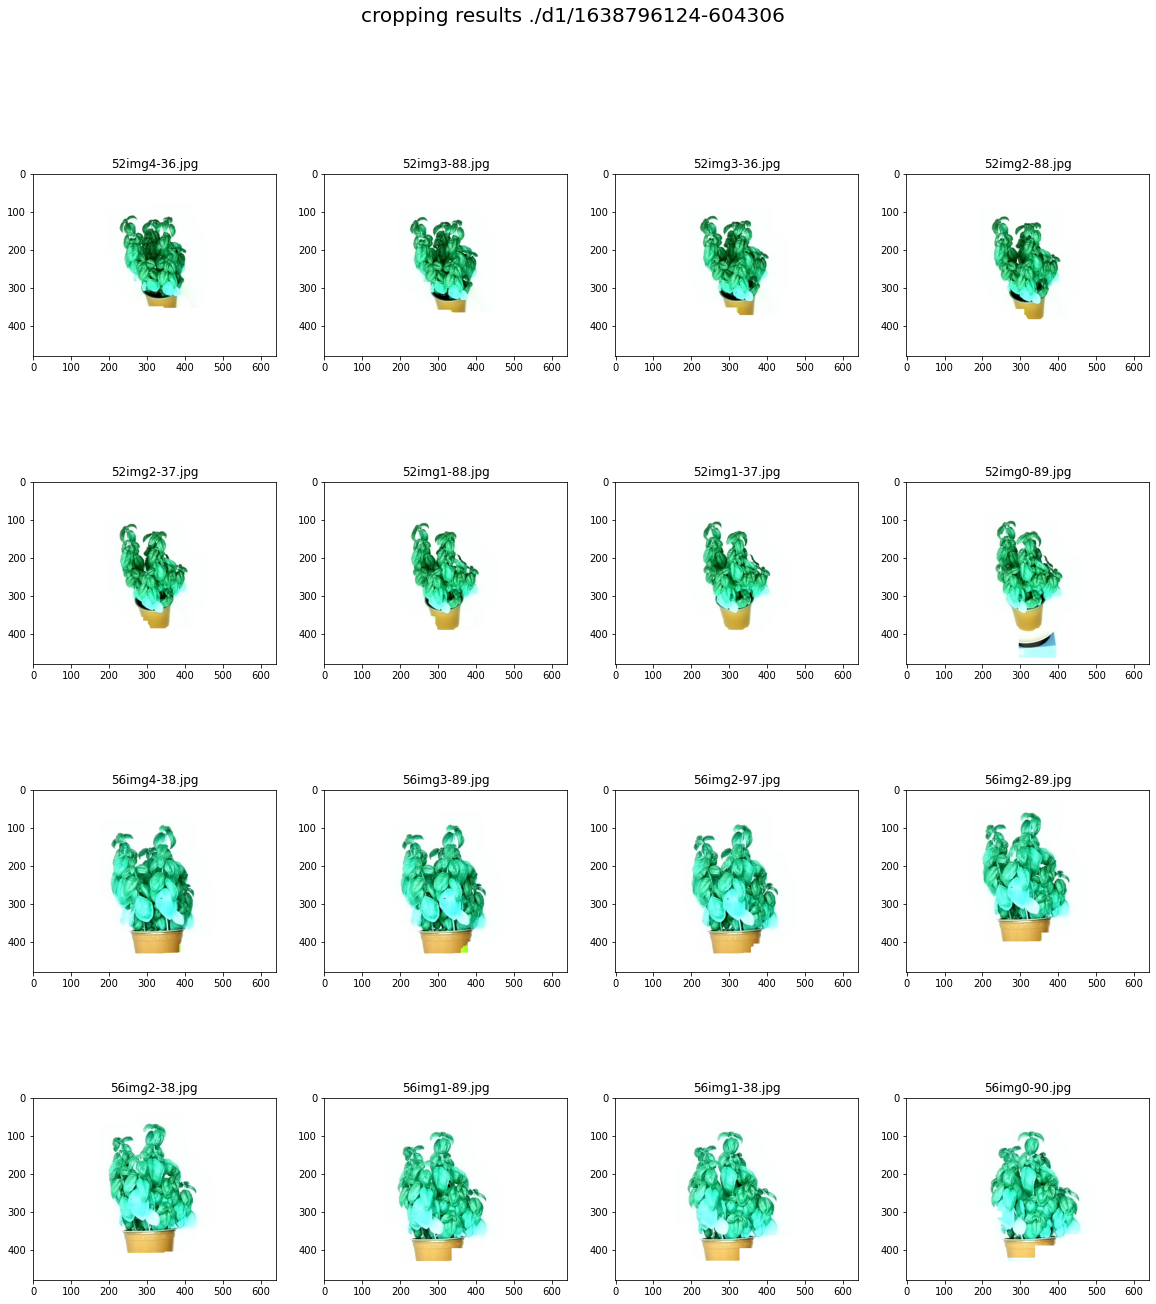

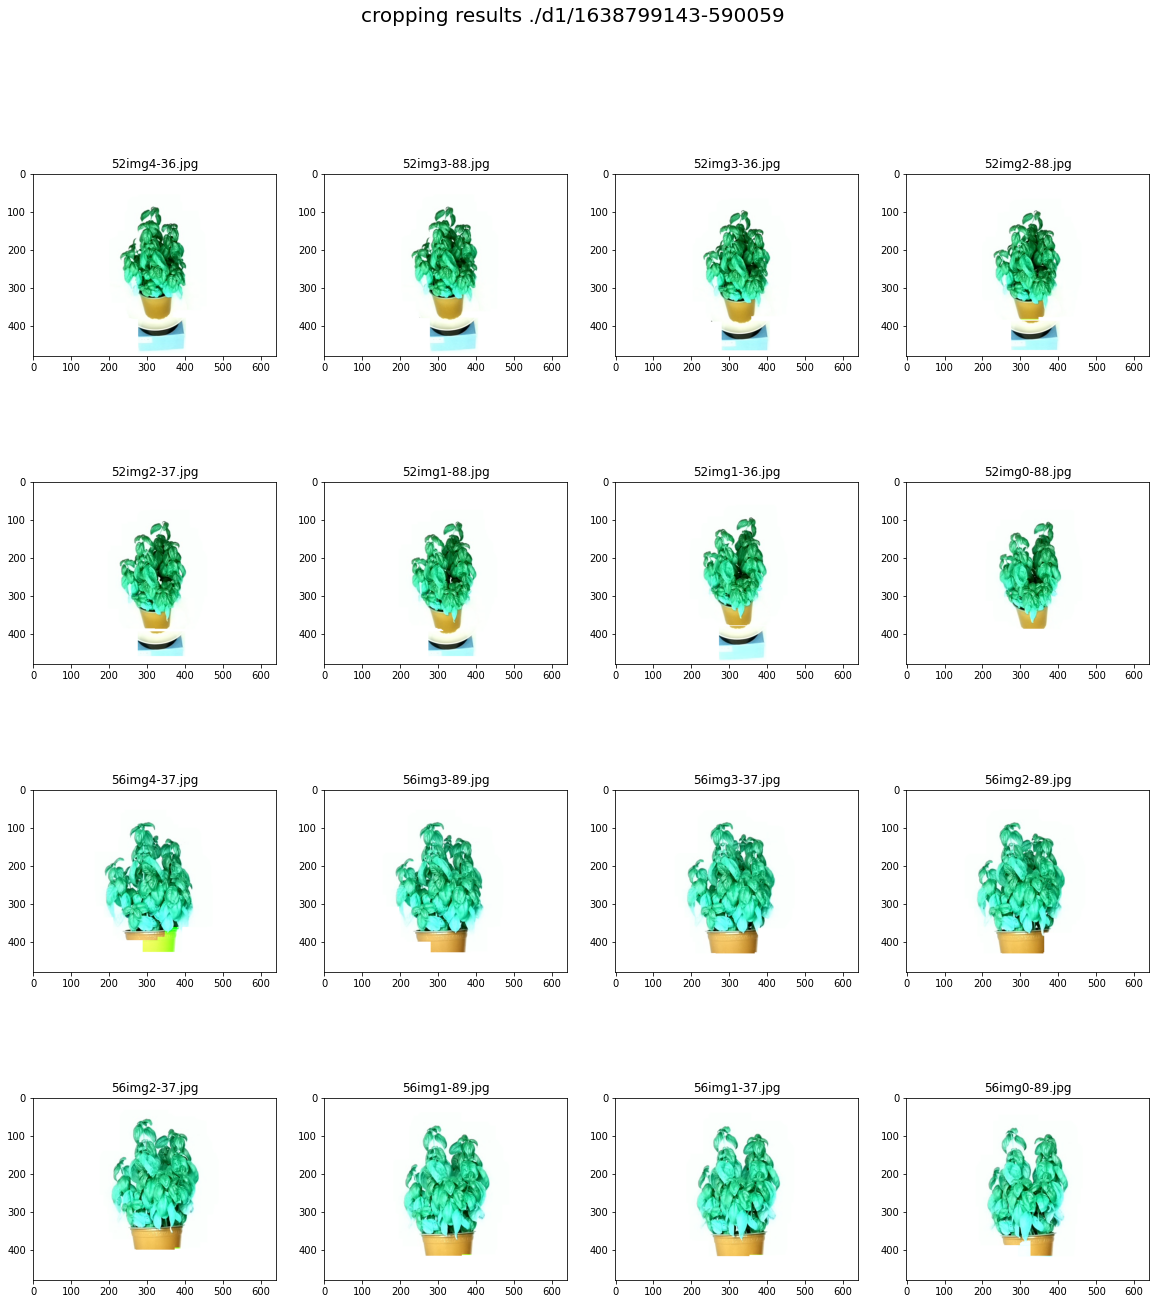

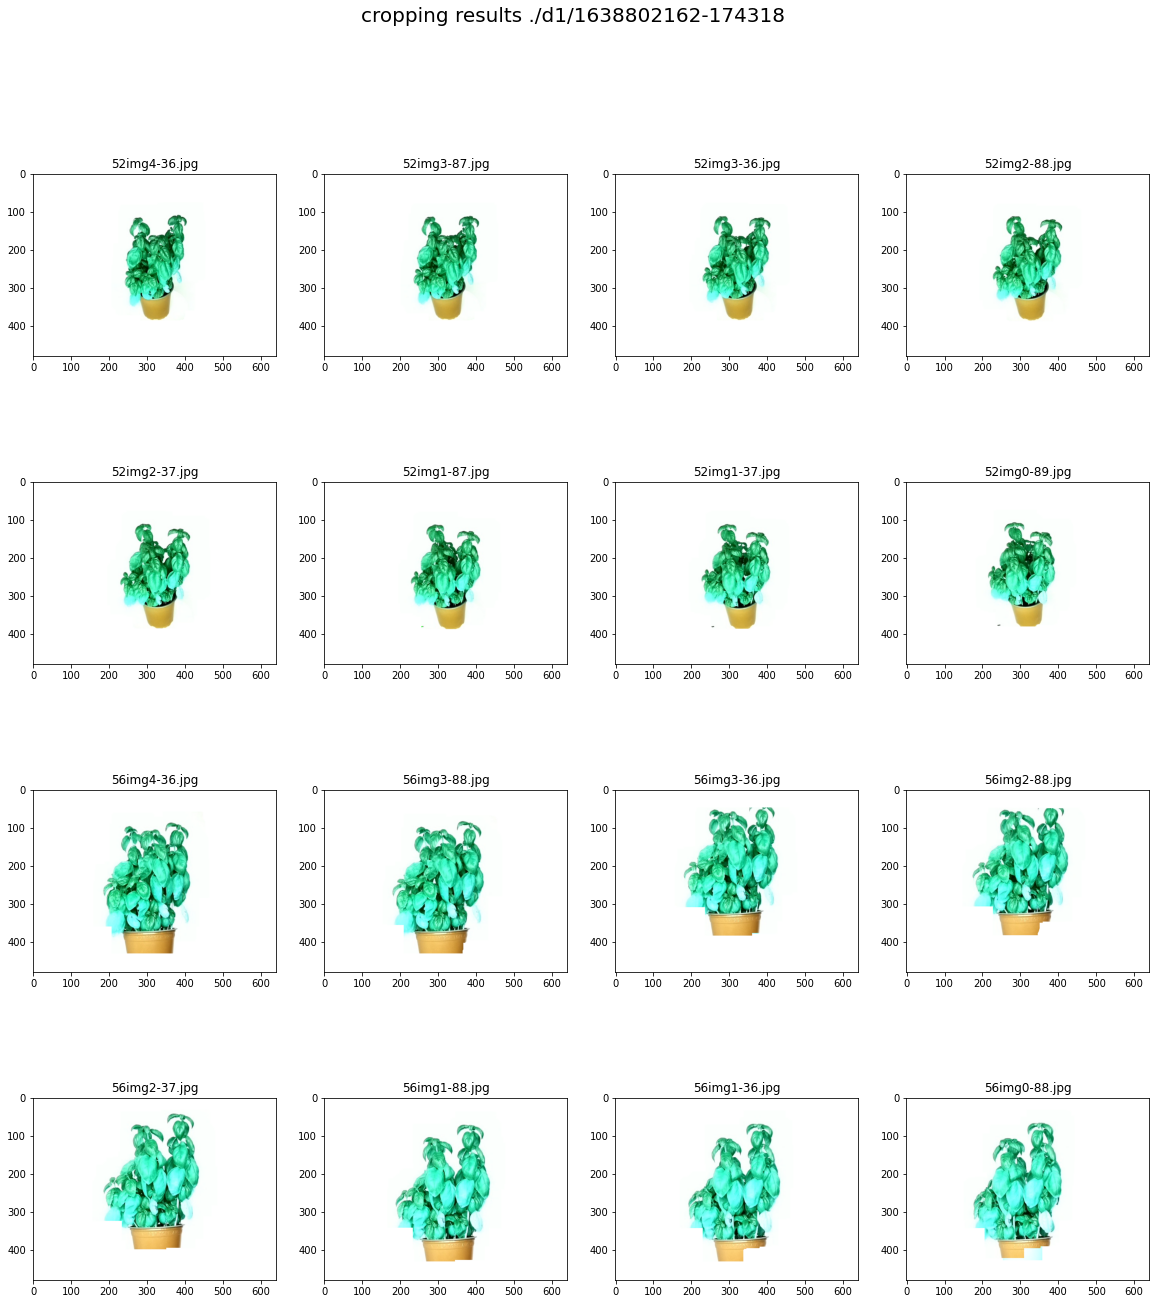

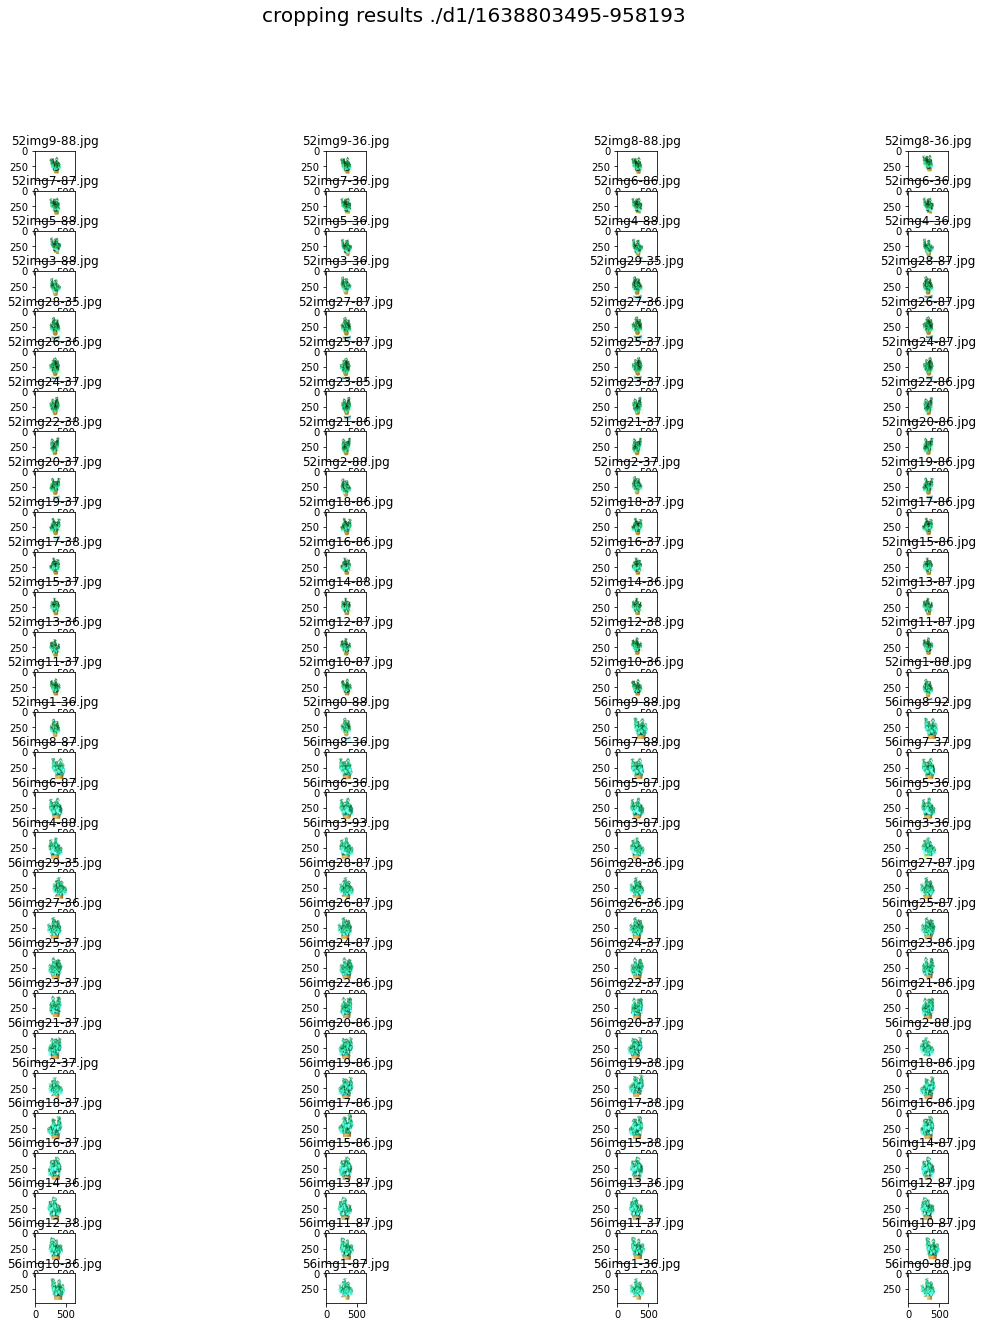

In [240]:
crop_all_and_plot(apply_mask=True,rescale=True ,save_to_local=True, plot=True)